In [1]:
import time
import pandas as pd
import seaborn as sns
from numpy import mean
from datetime import datetime
import dataframe_image as dfi
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
%config InlineBackend.figure_format = 'retina'

In [2]:
csvPath = 'YouTubeDataset_withChannelElapsed.csv'
orginalData = pd.read_csv(csvPath)

# 1. Data Preprocessing

In [3]:
# 1. Unique: Set videoID to index and Drop duplicate data
#            Delete attributes ['index', 'likes/dislikes', 'channelId']
data = orginalData.drop_duplicates(subset=['videoId'])
data = data.set_index(['videoId']).drop(['index', 'likes/dislikes', 'channelId'], axis=1)

# 2. DropNA: Drop all null and meaningless values
#            Delete by row if attributes' value is -1 in data
dropFilterStr = ''.join([f"(data['{attribute}'] == -1) | " for attribute in data])
data = data.drop(data[eval(dropFilterStr[:-3])].index, axis=0)

# 3. TimeStamp: Transfer time format to timestamp
#               2012-01-19T18:38:28.000Z -> 1326902400
data['videoPublished'] = data['videoPublished'].apply(lambda x:int(time.mktime(datetime.strptime(x[:10], "%Y-%m-%d").timetuple())))

# 2. Draw Correlation Heatmap

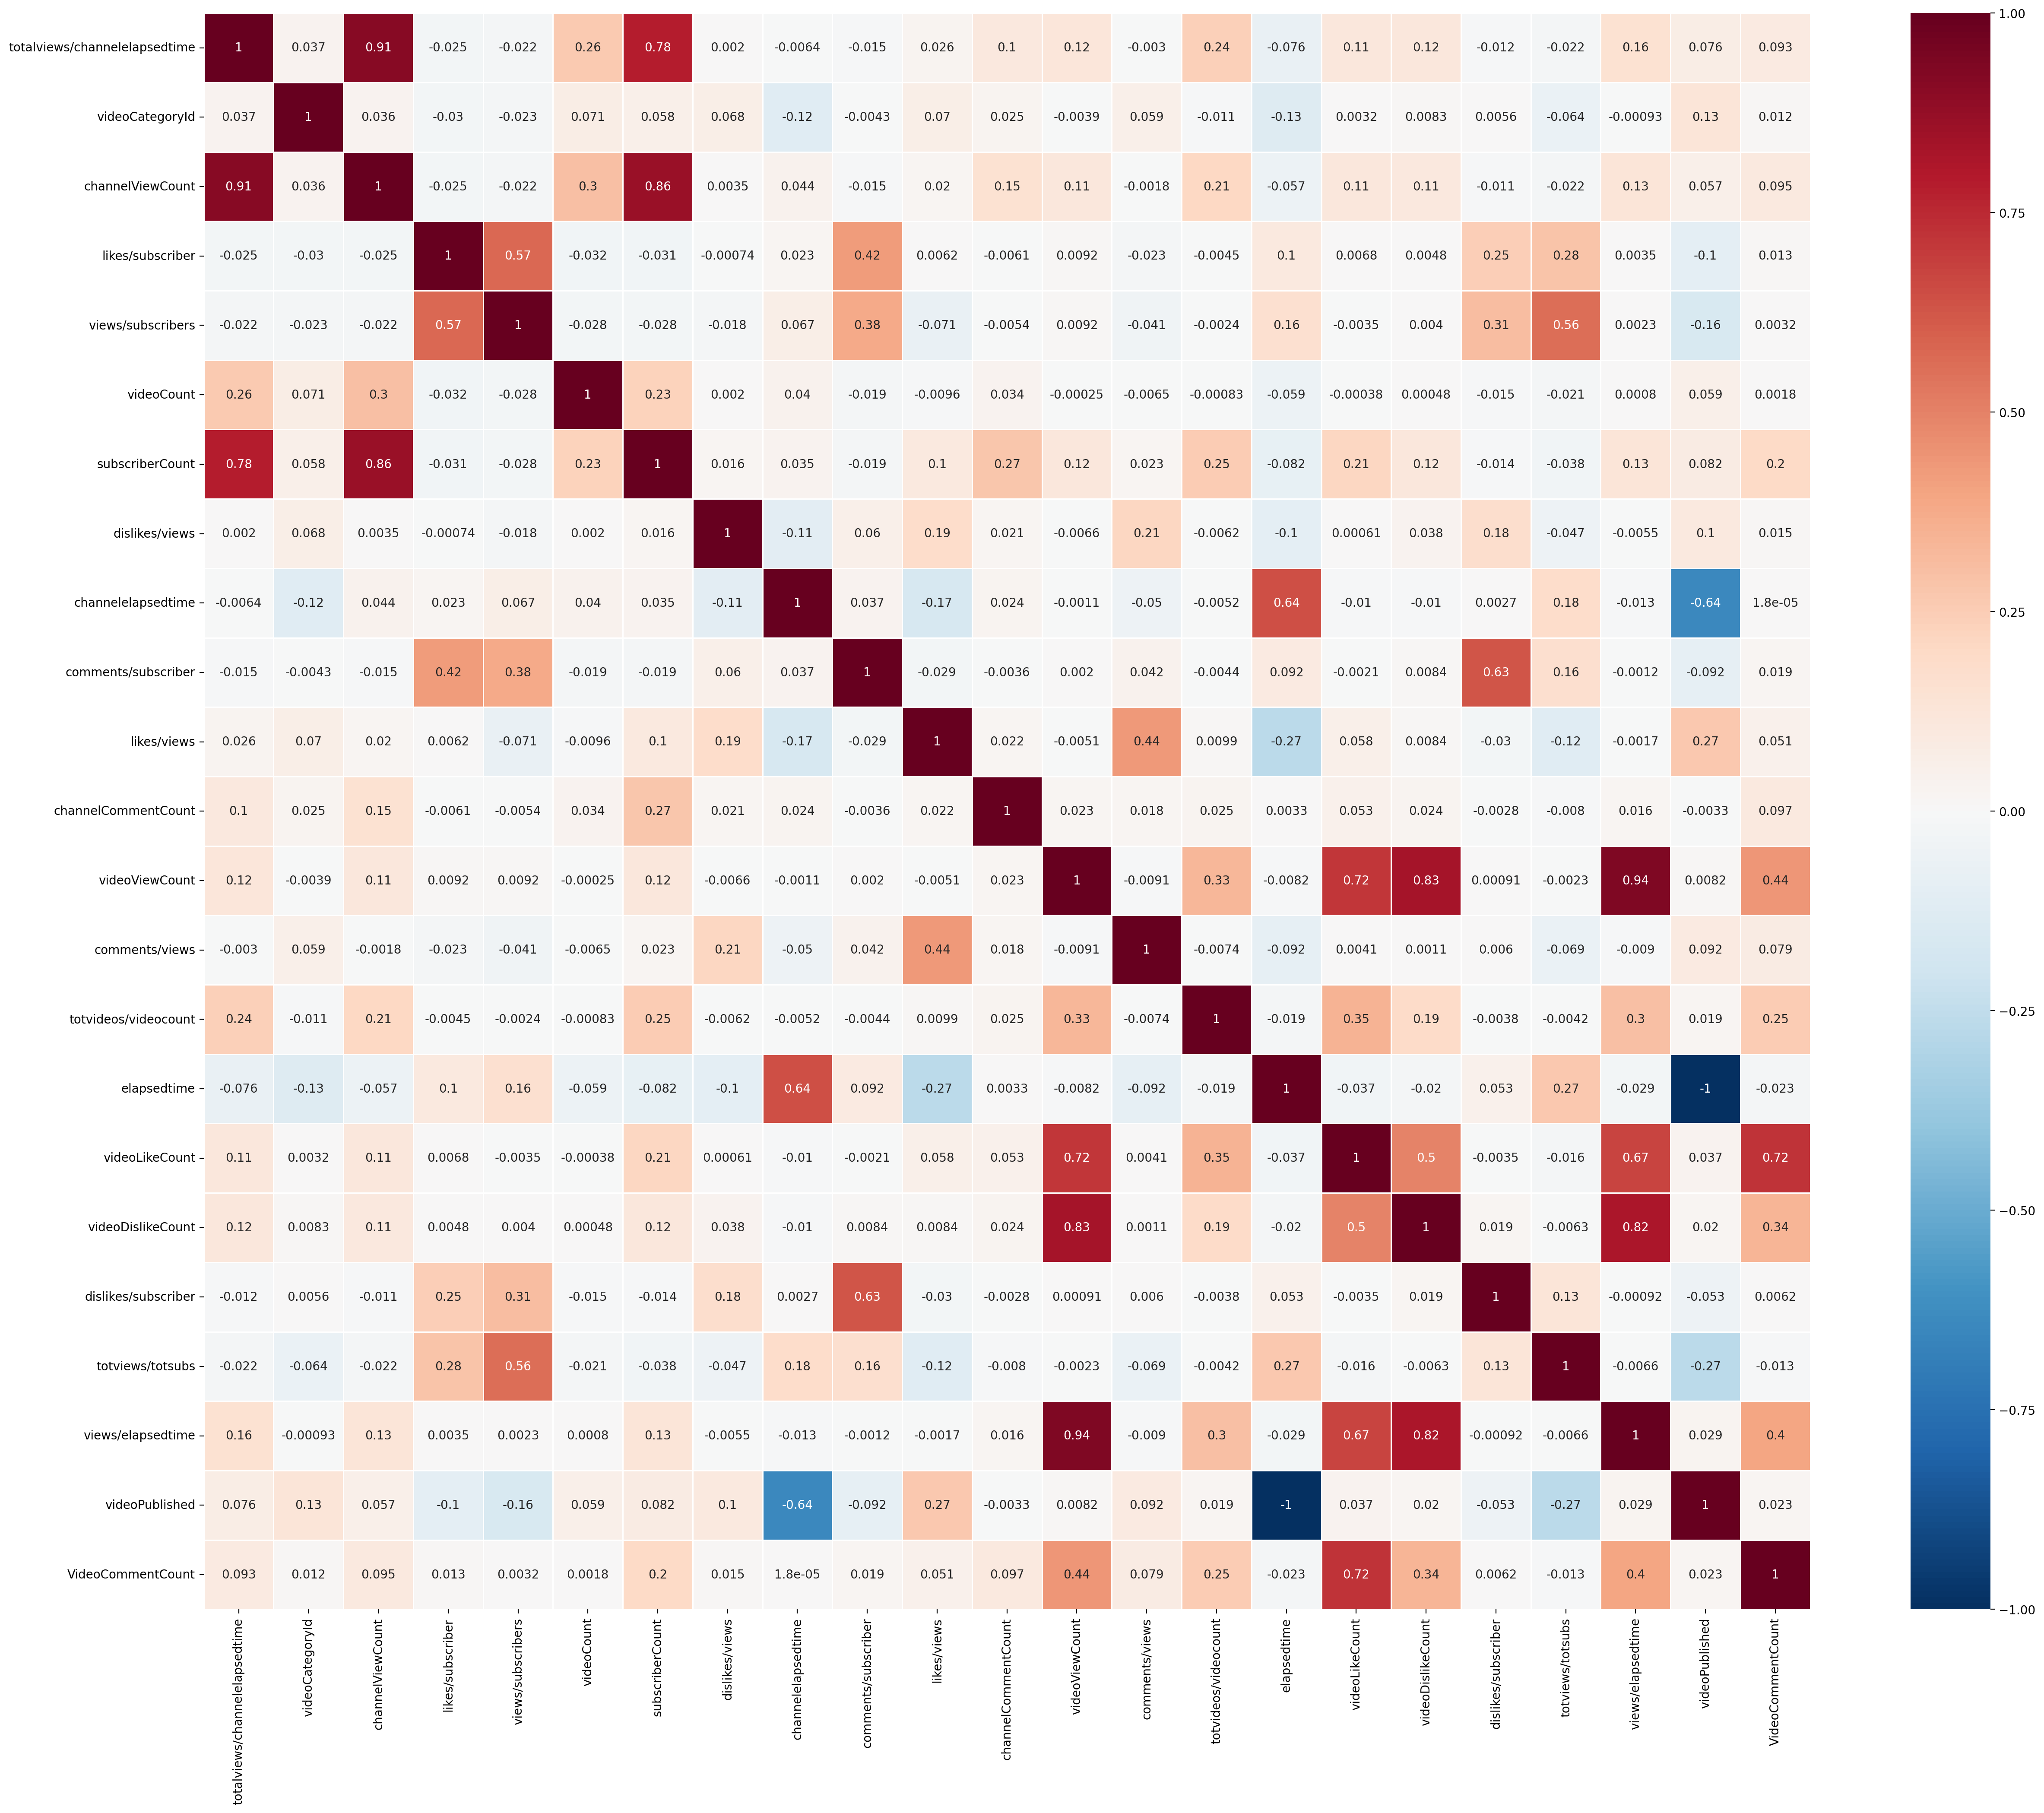

In [4]:
# Use minmax to normalize (value between 0 ~ 1)
normalizedDF_minmax = (data - data.min()) / (data.max() - data.min())
normalizedDF_correlation = normalizedDF_minmax.corr()
plt.figure(figsize=(30, 24))
sns.heatmap(normalizedDF_correlation, cmap='RdBu_r', linewidths=0.5, vmin=-1, vmax=1, annot=True)
plt.show()

# 3. Scatter Plot Between Two Attributes

In [5]:
def draw_scatter(data, attributeName1, attributeName2):
    # Use minmax to normalize (value between 0 ~ 1)
    attribute1_minmax = (data[attributeName1] - data[attributeName1].min()) / (data[attributeName1].max() - data[attributeName1].min())
    attribute2_minmax = (data[attributeName2] - data[attributeName2].min()) / (data[attributeName2].max() - data[attributeName2].min())
    plt.scatter(list(attribute1_minmax), list(attribute2_minmax), s=3, c='red')
    plt.xlabel(attributeName1)
    plt.ylabel(attributeName2)
    plt.show()

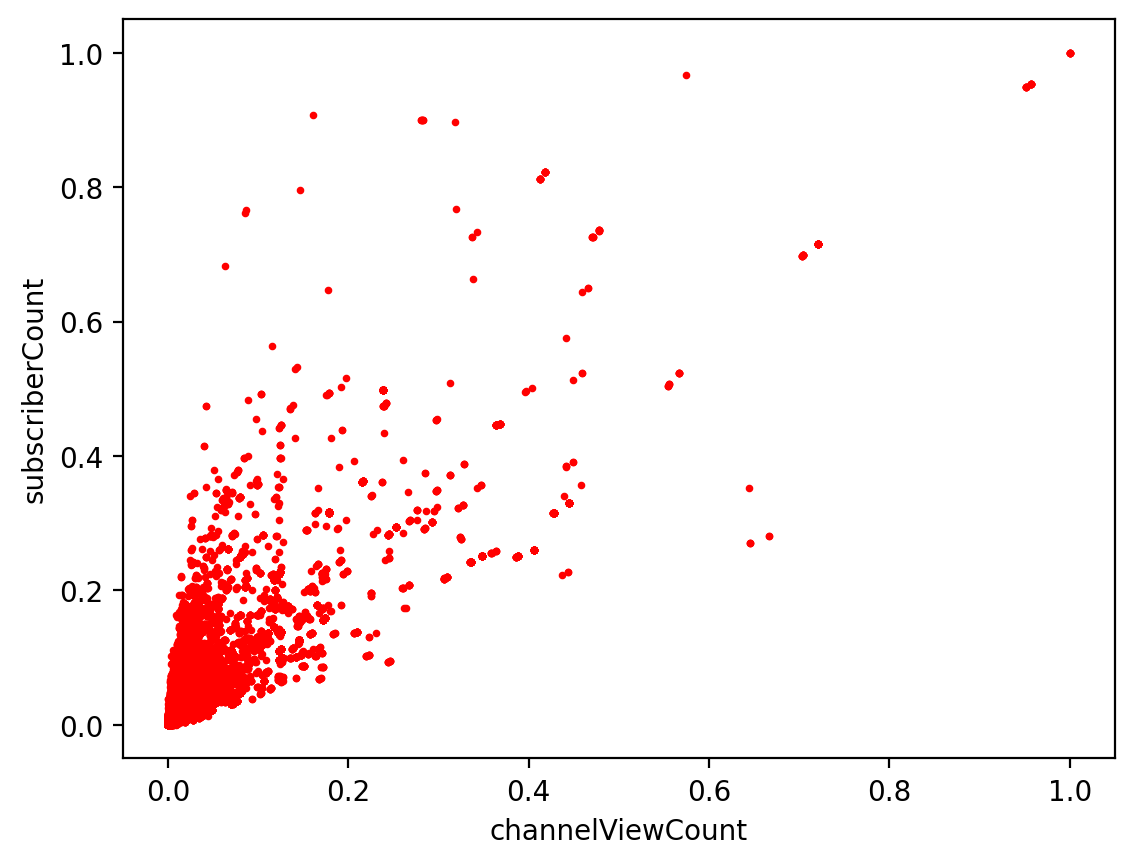

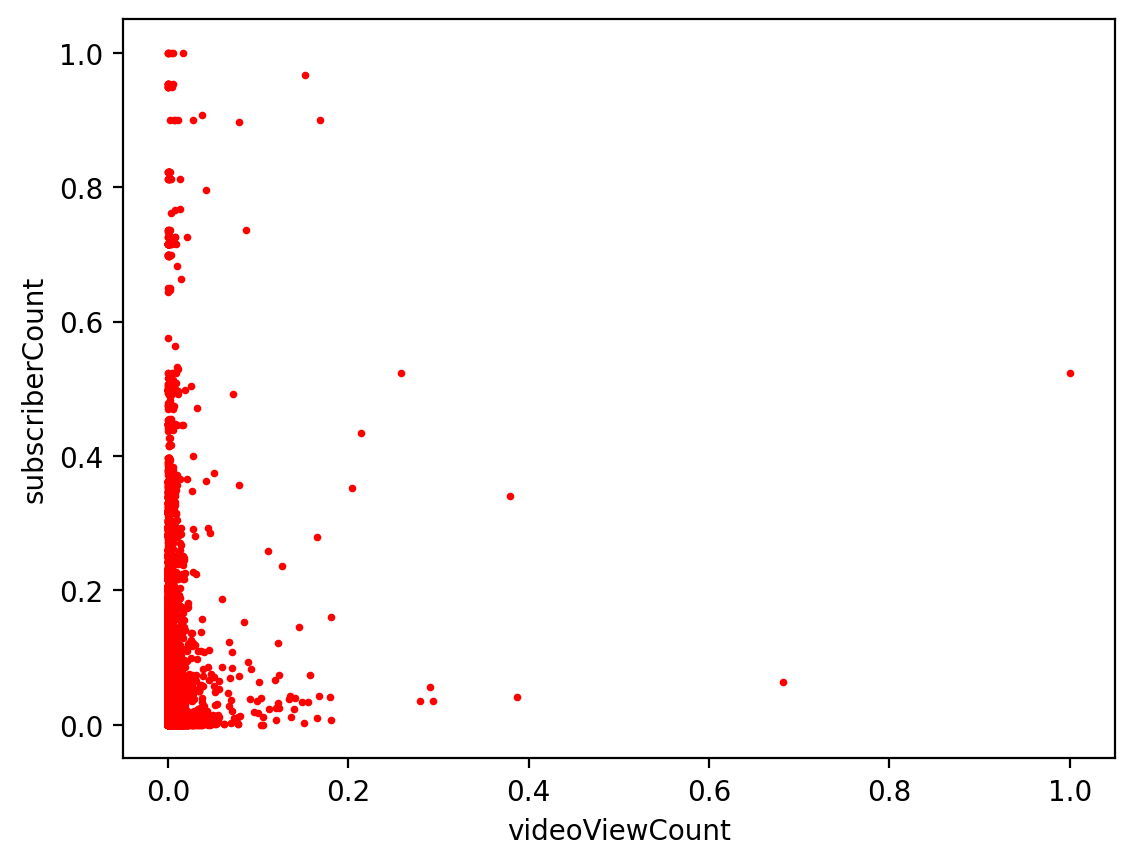

In [6]:
draw_scatter(data, 'channelViewCount', 'subscriberCount')
draw_scatter(data, 'videoViewCount', 'subscriberCount')

# 4. Group By VideoCategory

In [7]:
# Add attribute videoCategory
videoCategory = [['2', 'Autos & Vehicles'], ['1', 'Film & Animation'], ['10', 'Music'], ['15', 'Pets & Animals'], ['17', 'Sports'], ['18', 'Short Movies'], ['19', 'Travel & Events'], ['20', 'Gaming'], ['21', 'Videoblogging'], ['22', 'People & Blogs'], ['23', 'Comedy'], ['24', 'Entertainment'], ['25', 'News & Politics'], ['26', 'Howto & Style'], ['27', 'Education'], ['28', 'Science & Technology'], ['29', 'Nonprofits & Activism'], ['30', 'Movies'], ['31', 'Anime/Animation'], ['32', 'Action/Adventure'], ['33', 'Classics'], ['34', 'Comedy'], ['35', 'Documentary'], ['36', 'Drama'], ['37', 'Family'], ['38', 'Foreign'], ['39', 'Horror'], ['40', 'Sci-Fi/Fantasy'], ['41', 'Thriller'], ['42', 'Shorts'], ['43', 'Shows'], ['44', 'Trailers']]
for item in videoCategory:
    (data.loc[data['videoCategoryId'] == int(item[0]), 'videoCategory']) = item[1]

In [8]:
# Group by videoCategory and count number of videos of each group
dataGroup = data.groupby('videoCategory')
channelCount = [(category, len(dataGroup.get_group(category))) for category in dataGroup.groups.keys()]

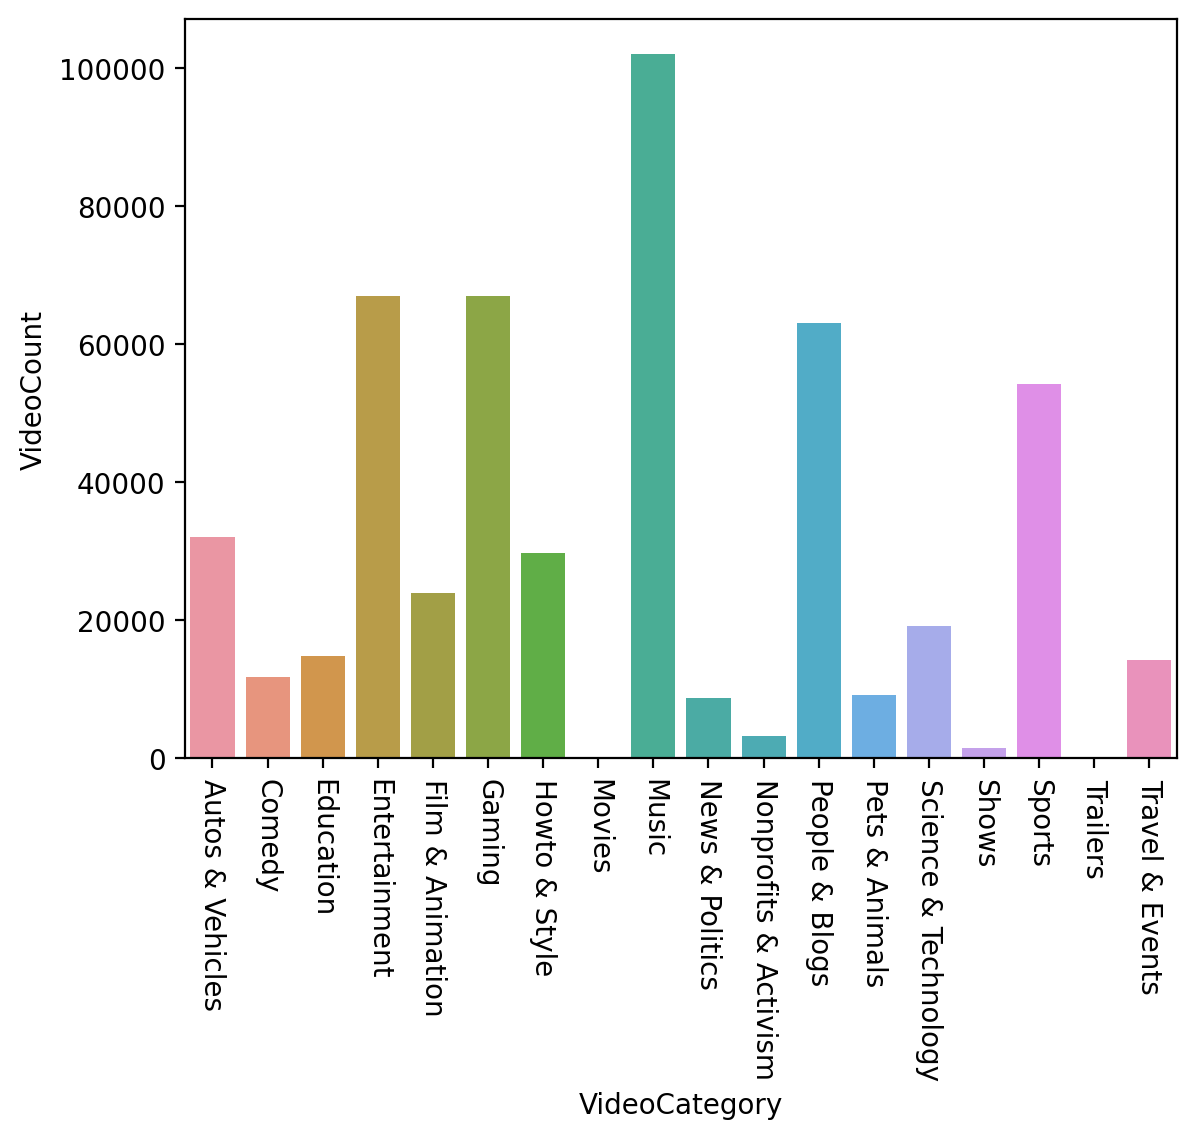

In [9]:
df = pd.DataFrame({
        'VideoCategory': [i[0] for i in channelCount],
        'VideoCount': [i[1] for i in channelCount]
    })

ax = sns.barplot(x='VideoCategory', y='VideoCount', data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=-90)
plt.show()

# 5. Mean By Group and Analysis

In [10]:
dataGroupMean = dataGroup.mean()
dataGroupMean = dataGroupMean.drop(['videoCategoryId', 'videoPublished'], axis=1)
dataGroupMean['channelViewCount'] = dataGroupMean['channelViewCount'].astype(int)
dataGroupMean['subscriberCount'] = dataGroupMean['subscriberCount'].astype(int)

In [11]:
def draw_barplot(dataGroupMean, attributeName):
    df = pd.DataFrame({
        'VideoCategory': list(dataGroupMean[attributeName].index),
        attributeName.capitalize(): list(dataGroupMean[attributeName].values),
    })
    
    ax = sns.barplot(x='VideoCategory', y=attributeName.capitalize(), data=df)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=-90)
    plt.show()

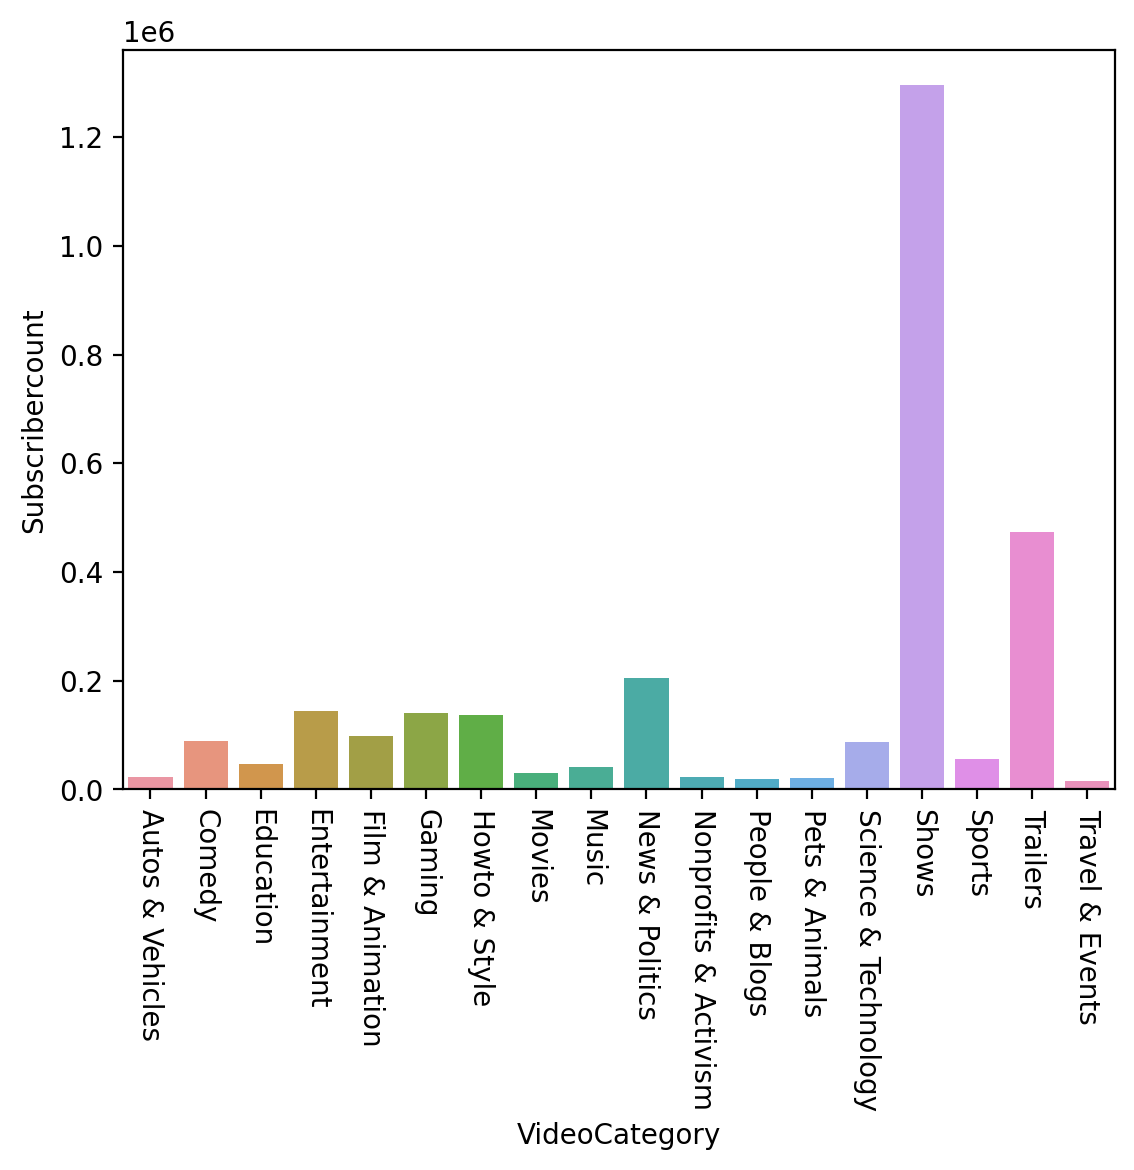

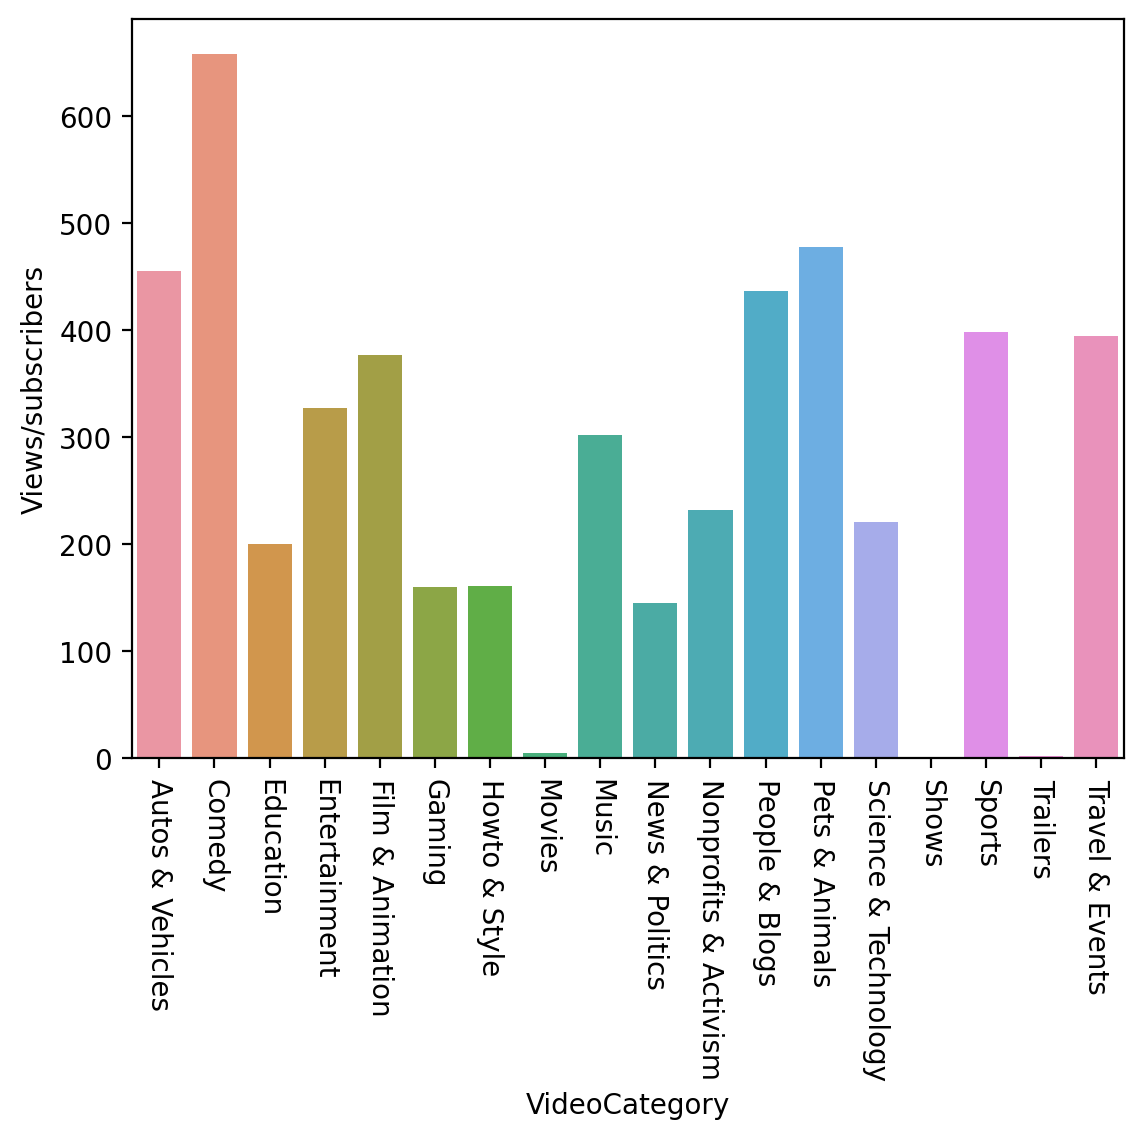

In [12]:
draw_barplot(dataGroupMean, 'subscriberCount')
draw_barplot(dataGroupMean, 'views/subscribers')

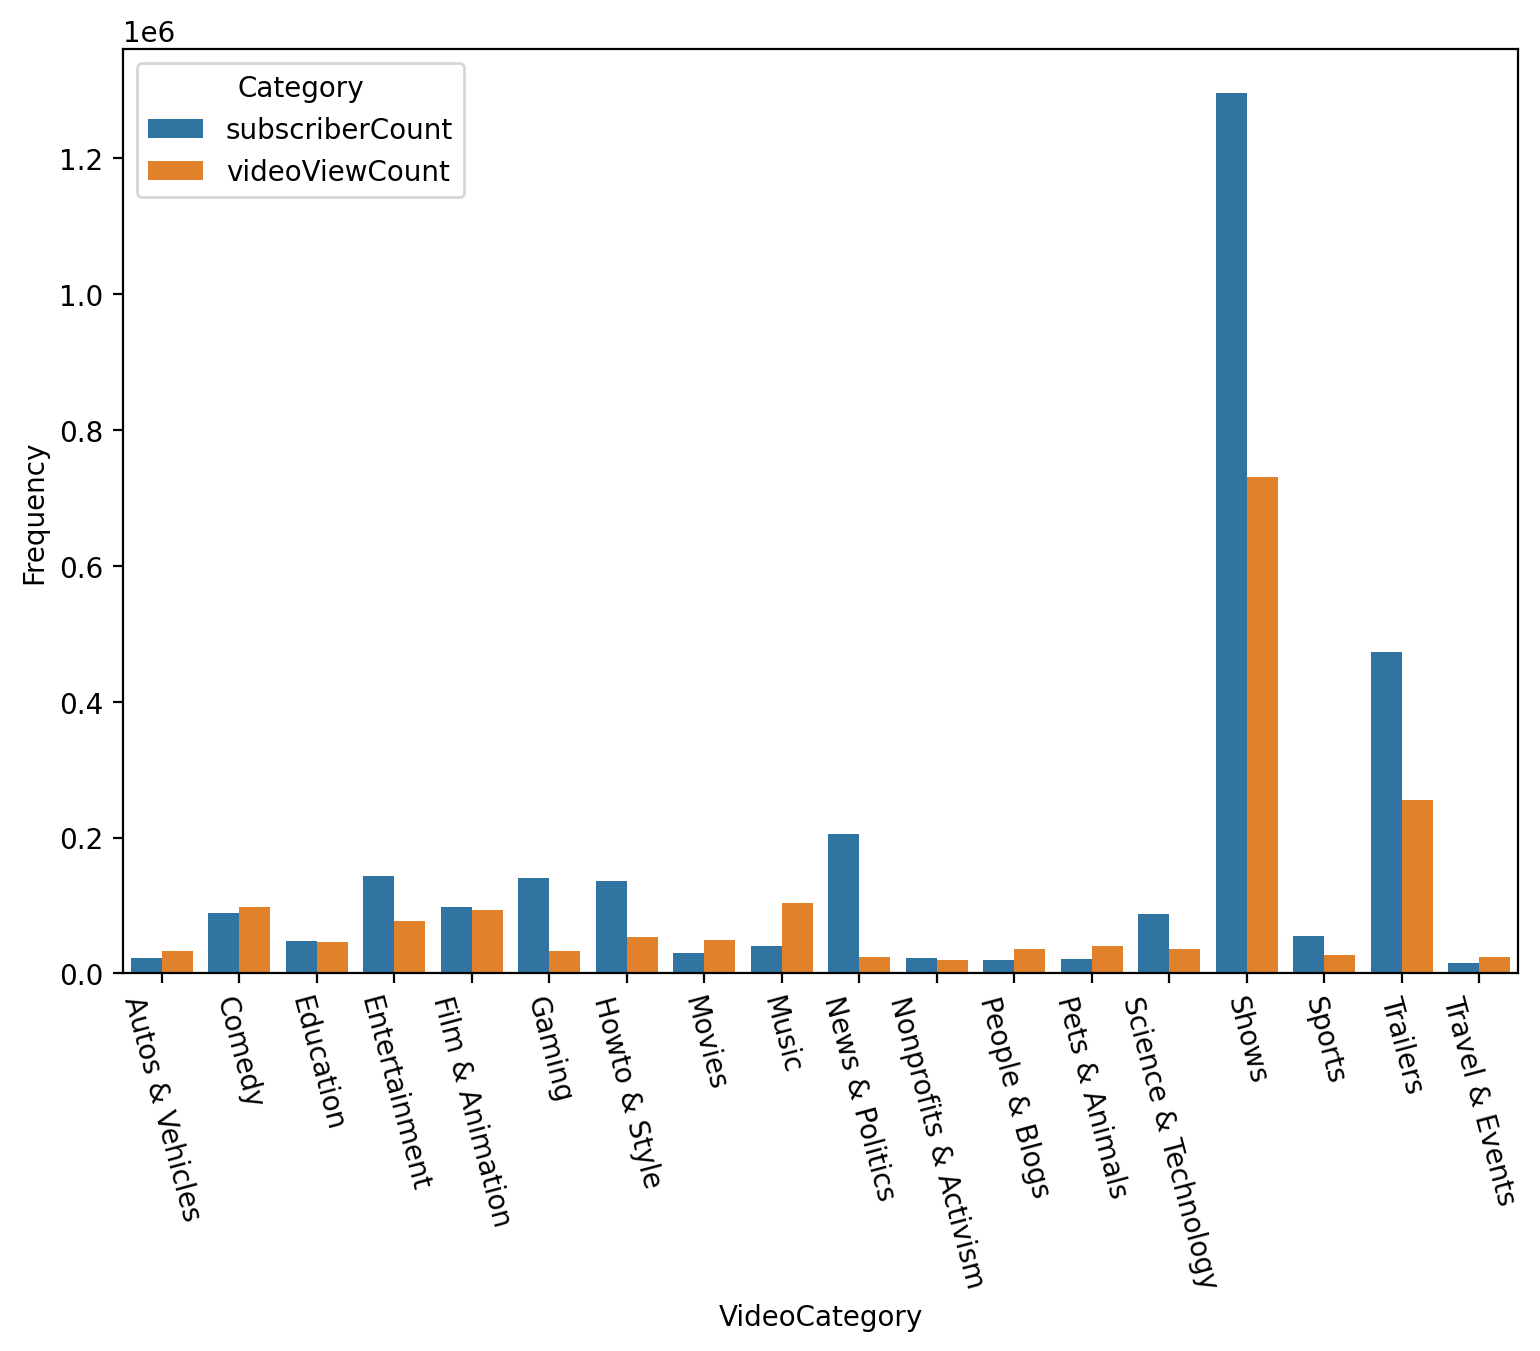

In [13]:
df = pd.DataFrame({
        'VideoCategory': list(dataGroupMean['subscriberCount'].index) + list(dataGroupMean['subscriberCount'].index),
        'Frequency': list(dataGroupMean['subscriberCount'].values) + list(dataGroupMean['videoViewCount'].values),
        'Category': ['subscriberCount' for _ in range(len(dataGroupMean['subscriberCount']))] + ['videoViewCount' for _ in range(len(dataGroupMean['subscriberCount']))]
    })

plt.figure(figsize=(9, 6))
ax = sns.barplot(x='VideoCategory', y='Frequency', data=df, hue=('Category'))
ax.set_xticklabels(ax.get_xticklabels(), rotation=-75)
plt.show()